<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.2: K-Means bad cases

INSTRUCTIONS:

- Replace the `___` with proper code to run the cells
- Observe and understand the results
- Answer the questions

In [1]:
## Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_circles

%matplotlib inline

In [2]:
## Create data points (circles)

# Make Random Circles
X1, _ = make_circles(n_samples = 400, factor = 0.3, noise = 0.05, random_state = 42)

In [3]:
X1.shape

(400, 2)

In [4]:
X1[:5]

array([[ 0.26102383,  0.12253848],
       [-0.24508728,  0.2022703 ],
       [ 0.48947133,  0.88264316],
       [ 0.36850544,  0.05574328],
       [-0.98127649,  0.19383238]])

In [5]:
## Convert data into a DataFrame

# Declare the column names
columns = 'A B'.split()

# Load the dataset as a pandas data frame
X = pd.DataFrame(X1, columns = columns)

In [6]:
## Check data

# About X
print('X is a %s\n' % type(X))
print('X has %d rows and %d columns\n' % X.shape)
print('Basic Statistics about X%s' % ('_'*10))
print(X.describe(), '\n')
print('Sample of X%s' % ('_'*24))
print(X.head())

X is a <class 'pandas.core.frame.DataFrame'>

X has 400 rows and 2 columns

Basic Statistics about X__________
                A           B
count  400.000000  400.000000
mean     0.004824    0.001917
std      0.522403    0.520935
min     -1.088607   -1.036946
25%     -0.279794   -0.270652
50%     -0.005778    0.000155
75%      0.298976    0.292112
max      1.146410    1.078468 

Sample of X________________________
          A         B
0  0.261024  0.122538
1 -0.245087  0.202270
2  0.489471  0.882643
3  0.368505  0.055743
4 -0.981276  0.193832


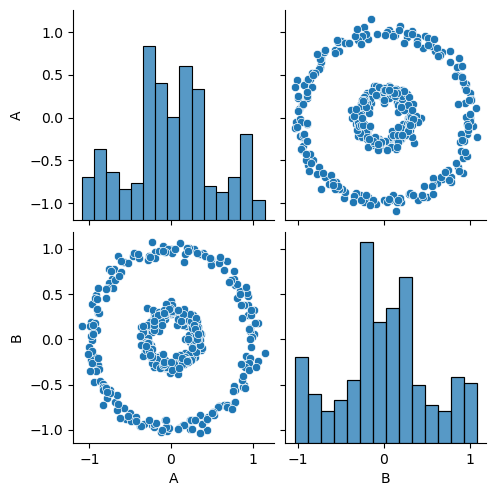

In [7]:
sns.pairplot(X);

### Question: What are other important things to know about the data? Comment on:
- Types
- Availability
- Dispersion and Distribution

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       400 non-null    float64
 1   B       400 non-null    float64
dtypes: float64(2)
memory usage: 6.4 KB


### Question: Which features could/should be used to cluster the data points?

* Data points of inner vs. outer circle should be clustered

In [9]:
## Create some supporting functions

# Create new centroids randomly for all the K clusters including all dimensions
def create_centroids(K, features):
    # start with No centroids
    centroids = []
    # need one centroid for each cluster
    for i in range(K):
        # it can be multi-dimensional
        dimensions = []
        for f in features:
            # create a random number between the minimum and maximum of each feature
            x = np.random.uniform(X[f].min(), X[f].max()) #__
            dimensions.append(x)
        # add all dimensions for the centroids of each cluster
        centroids.append(dimensions)

    return centroids

In [10]:
# Identify the closest centroid for a given data point
def closest_centroid(x, centroids):
    distances = []
    # convert x to a numpy.array; x contains all the features of a data point
    p = np.array(x)
    for c in centroids:
        # convert c to a numpy.array; c contains the coordinates for all the features
        q = np.array(c)
        # calculate the Euclidean distance between data point `x` and centroid `c`
        d = np.sqrt(np.square(p - q).sum()) #__
        # add the distance for each centroid
        distances.append(d)

    # return the position (cluster) which has the smallest distance
    return np.array(distances).argmin()

In [11]:
# Recalculate all the centroids based on the mean of the members of each cluster
def update_centroid(X, y, centroids):
    c = []
    # for each of the existing centroids
    for i in range(len(centroids)):
        # check if any object was assigned to a cluster
        if X[y == i].shape[0]:
            dimensions = []
            # for all the features
            for f in X.columns:
                # calculate the mean
                x = X[f][y == i].mean() #__
                dimensions.append(x)
            c.append(dimensions)
        # if a cluster got no members
        else:
            # keep the previous coordinates
            c.append(centroids[i])

    return c

In [12]:
# Plot a chart of the data points and centroids either generic or identifying the clusters
# NOTE: for visualisation purposes, only consider the first two features
def plot_data(ax, X, y, centroids, show_clusters = True):
    # unpack the coordinates of the centroids
    a = [z[0] for z in centroids]
    b = [z[1] for z in centroids]

    # show distinct colours if asked to identify the clusters
    if show_clusters:
        colours = 'rgbykcm'
        for i in range(len(centroids)):
            ax.scatter(X[features[0]][y == i], X[features[1]][y == i], c = colours[i], label = 'Cluster %d' % i)
    # show data points without cluster identification
    else:
        ax.scatter(X[features[0]], X[features[1]], label = 'Data Point')
        
    # label the features
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])

    # identify the centroids
    ax.scatter(a, b, c = 'k', linewidths = 5, marker = 'x', label = 'Centroid')
    for i in range(len(a)):
        c = colours[i] if show_clusters else 'k'
        ax.axvline(x = a[i], color = c, linestyle = '--', linewidth = 1)
        ax.axhline(y = b[i], color = c, linestyle = '--', linewidth = 1)

    # create a text to show the centroids' coordinates
    t = '\n'.join(['%d: (%.3f, %.3f)' % (i, a, b) for (i, (a, b)) in enumerate(centroids)])
    ax.text(0.69, -1.1, t)

    ax.legend(loc='upper left')

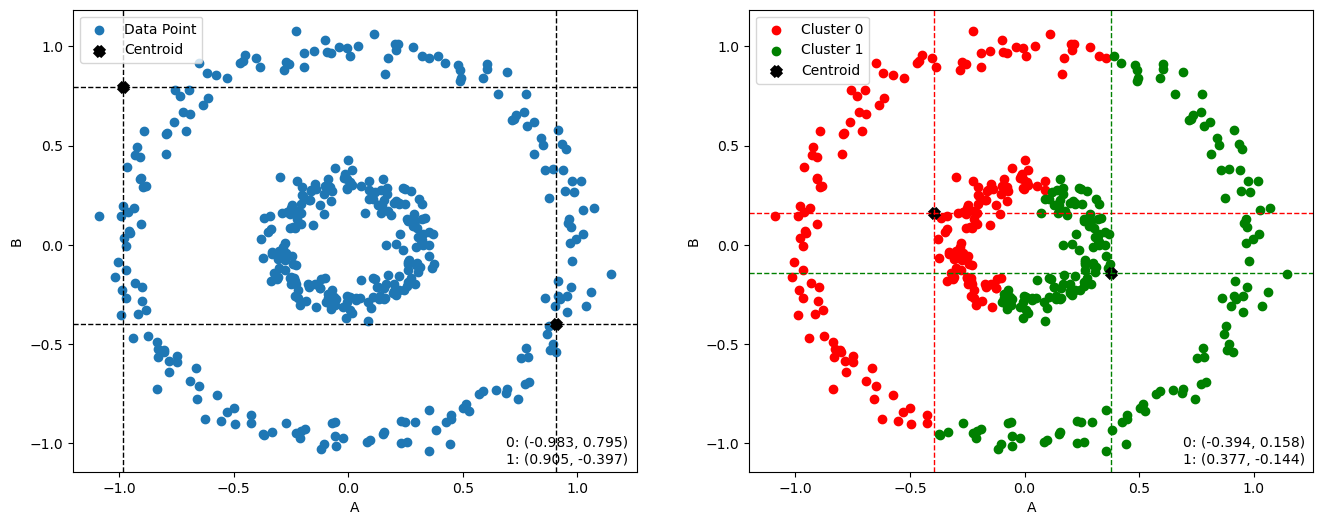

In [13]:
## K_Means
## Note that the comments match the outlined K-Means Algorithm in the presentation

# 1. Define the number of clusters `K`
K = 2 # choose different values for `K`

# list the features to be used
features = ['A', 'B']

# 2. Select `K` cluster centres randomly
centroids = create_centroids(K, features)

# plot the data points and initial centroids (the 'Before')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
plot_data(axes[0], X[features], None, centroids, False)

# Repeat until centroids make no more moves
while True:
    # 3. Calculate the distance between each data point and cluster centres
    # 4. Assign the data point to the cluster whose distance from its centre is minimum
    y = X[features].apply(lambda x: closest_centroid(x, centroids), axis=1).values #___
    
    # move the known assignment be the previous state, for post comparison
    old_c = centroids.copy()

    # 5. Recalculate all new cluster centres by averaging the objects of each cluster
    centroids = update_centroid(X[features], y, centroids)

    # 6. Repeat steps 3 to 5 until the centroids do not change
    if old_c == centroids:
        break

# plot the data points identified by cluster and final centroids (the 'After')
plot_data(axes[1], X[features], y, centroids);

### Question: What happens if the algorithm is run multiple times?

* Centroids just move around the circle

### Question: What happens if `K` is changed?

* Circles are equally divided by the numbers of clusters and look like a donut or pie chart
* K-Means does not work for circular data

# Bonus

Check out if other clustering algorithms are doing a better job on circular data.

For more comparisons on toy datasets refer to 

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py


##  Hierarchical Clustering

In [14]:
from sklearn.cluster import AgglomerativeClustering

In [15]:
hc = AgglomerativeClustering(n_clusters=2, affinity='euclidean')
hc.fit(X)

AgglomerativeClustering()

In [16]:
hc.labels_

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,

In [17]:
# Add labels
X['hc_labels'] = hc.labels_
X.head(3)

,A,B,hc_labels
0,0.261024,0.122538,0
1,-0.245087,0.202270,0
2,0.489471,0.882643,1


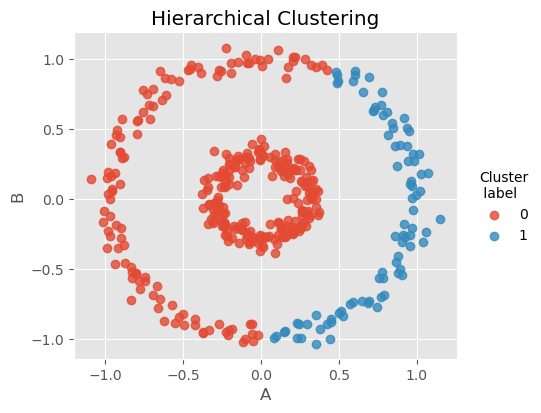

In [18]:
# Plot clusters
plt.style.use('ggplot')

ax1 = sns.lmplot(x='A', y='B', data=X, hue='hc_labels', height=4, aspect=1.2, fit_reg=False)
ax1.set(title='Hierarchical Clustering', xlabel='A', ylabel='B')
ax1._legend.set_title('Cluster\n label');

## DBSCAN - Density-Based Spatial Clustering of Applications with Noise

In [19]:
from sklearn.cluster import DBSCAN

Epsilon is the most important DBSCAN parameter to choose and it is defined as the maximum distance between two samples for one to be considered as in the neighborhood of the other. To determine the value for the epsilon parameter in DBSCAN use kNN below.

In [20]:
db = DBSCAN(eps=0.1, min_samples=10)
db.fit(X)

DBSCAN(eps=0.1, min_samples=10)

In [21]:
db.labels_

array([ 0,  0, -1,  0, -1, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1, -1,  0,
        0,  0,  0, -1, -1,  0,  0, -1,  0, -1,  0,  0, -1,  0, -1,  0, -1,
        0, -1, -1,  0, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
        0,  0, -1,  0, -1,  0, -1, -1, -1, -1,  0,  0, -1, -1, -1,  0,  0,
        0, -1,  0, -1, -1, -1,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,  0,
       -1,  0,  0, -1, -1,  0,  0, -1,  0, -1,  0,  0,  0,  0, -1,  0, -1,
       -1, -1, -1, -1, -1, -1,  0,  0, -1,  0,  0,  0,  0, -1, -1,  0,  0,
        0, -1, -1, -1,  0, -1, -1,  0,  0, -1,  0,  0, -1,  0, -1, -1, -1,
        0,  0,  0,  0, -1, -1,  0, -1, -1,  0, -1, -1, -1,  0, -1,  0, -1,
       -1, -1, -1, -1, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1, -1,  0,
       -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,
        0,  0, -1, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1, -1, -1,  0, -1,  0, -1, -1,  0,  0, -1,  0,  0,  0,  0,  0,
       -1,  0, -1, -1, -1

In [22]:
# Add labels
X['db_labels'] = db.labels_

In [23]:
X.head(3)

,A,B,hc_labels,db_labels
0,0.261024,0.122538,0,0
1,-0.245087,0.202270,0,0
2,0.489471,0.882643,1,-1


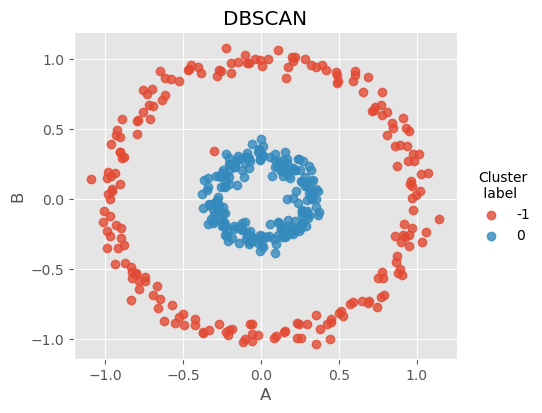

In [24]:
# Plot clusters
plt.style.use('ggplot')

ax1 = sns.lmplot(x='A', y='B', data=X, hue='db_labels', height=4, aspect=1.2, fit_reg=False)
ax1.set(title='DBSCAN', xlabel='A', ylabel='B')
ax1._legend.set_title('Cluster\n label');

## k-Nearest Neighbours (kNN)

To find the distance between a point and its nearest data point for all data points in the dataset use NearestNeighbors and plot the distances in a k-distance graph

In [25]:
from sklearn.neighbors import NearestNeighbors

In [26]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

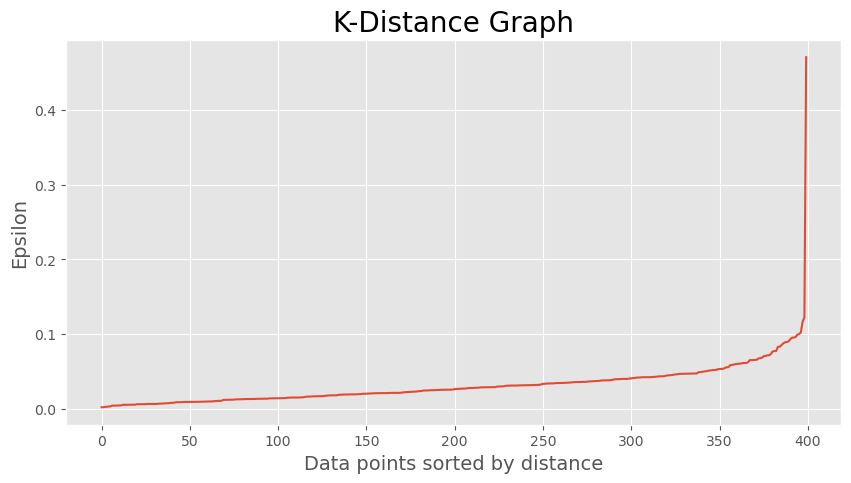

In [27]:
# Plotting K-distance graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('K-Distance Graph',fontsize=20)
plt.xlabel('Data points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14);

* The optimum value of epsilon is at the point of maximum curvature in the K-Distance Graph, which is 0.1 in this case

>

>

>



---



---



> > > > > > > > > © 2022 Institute of Data


---



---



